# DQN training on our own gridworld

In [ ]:
! pip install gym tqdm torchvision

## Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd

import time
import gym

import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from tqdm import tqdm
import random

import torch.nn.functional as F
import torch 
from torch import nn
import torch.optim as optim
import torchvision.transforms as T
from PIL import Image
from collections import deque

import time

## Importing the custom environment

In [3]:
from mario import MyMarioEnvironment

## DQN network with fully connected layers

In [4]:
class DQN_FC(nn.Module):
    def __init__(self, i, o):
        super(DQN_FC, self).__init__()
        self.fc1 = nn.Linear(in_features=i, out_features=8)
        self.fc2 = nn.Linear(in_features=8, out_features=8)
        self.fc3 = nn.Linear(in_features=8, out_features=o)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x    

## DQN network with convolutional layers

Not used for solving the custom grid environment. Present for future use.

In [5]:
class DQN_CNN(nn.Module):
    def __init__(self, h, w, o):
        super(DQN_CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=16, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(in_channels=16,out_channels=32, kernel_size=4, stride=2)
        # print(self.conv_output_shape(h,8,4,0,1))
        out_conv_h = self.conv_output_shape(self.conv_output_shape(h,8,4,0,1),4,2,0,1)
        out_conv_w = self.conv_output_shape(self.conv_output_shape(w,8,4,0,1),4,2,0,1)
        self.fc = nn.Linear(in_features=out_conv_h*out_conv_w*32, out_features=o)
        # print(h,w, out_conv_h,out_conv_w)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        x = self.relu(self.conv1(x))
        # print("c1",x.shape)
        x = self.relu(self.conv2(x))
        # print("c2",x.shape)
        x = self.sigmoid(self.fc(self.flatten(x)))
        return x
    
    def conv_output_shape(self, size, kernel_size=1, stride=1, pad=0, dilation=1):
        from math import floor
        if type(kernel_size) is not tuple:
            kernel_size = (kernel_size, kernel_size)
        out = floor( ((size + (2 * pad) - ( dilation * (kernel_size[0] - 1) ) - 1 )// stride) + 1)
        return out

## Class for DQN Implementation

In [6]:
class GridVanillaDQN():
    def __init__(self, env, typ="dense"):
      self.env = env
      self.typ = typ
      self.max_episodes = 2500
      self.max_steps = 30
      self.gamma = 0.90
      self.epsilon = 1.0
      self.epsilon_min = 0.01
      self.epsilon_decay_lamda = self.epsilon_min**(1/self.max_episodes)
      self.target_update_counter = 0
      self.target_update_frequency = 10
      self.buffer_minibatch_size = 50
      self.replay_buffer_capacity=4000
      self.replay_buffer = deque([],maxlen=self.replay_buffer_capacity)
      self.resize = T.Compose([T.ToPILImage(),
                    T.Resize(84, interpolation=Image.CUBIC),
                    T.Grayscale(),
                    T.ToTensor()])  
      env.reset()
#       _, _, self.state_screen_h, self.state_screen_w = self.screen_preprocessor(self.env.render()).shape
      self.state_count = env.observation_space.n
      self.action_count = env.action_space.n
      self.target_dqn = DQN_FC(self.action_count+1, self.action_count) if self.typ=="dense" else DQN_CNN(self.state_screen_h,self.state_screen_w,self.action_count)
      self.q_value_dqn = DQN_FC(self.action_count+1, self.action_count) if self.typ=="dense" else DQN_CNN(self.state_screen_h,self.state_screen_w,self.action_count)
      # self.rms_optimizer = optim.RMSprop(self.q_value_dqn.parameters())#, lr=0.001)#, weight_decay=0.05)
      # self.loss_func = F.smooth_l1_loss
      self.rms_optimizer = optim.SGD(self.q_value_dqn.parameters(), lr=0.001)#optim.RMSprop(self.q_value_dqn.parameters(), lr=0.001)#, weight_decay=0.05)
      self.loss_func = F.mse_loss #F.smooth_l1_loss
      
      self.timestep_list = []
      self.rewards_list = []
      self.epsilon_list = []
      
      self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
      self.q_value_dqn#.to(self.device)
      self.target_dqn#.to(self.device)

      self.test_max_episodes = 10
      self.test_timestep_list = []
      self.test_rewards_list = []
      self.test_epsilon_list = []
      self.trained_policy_path = "./grid.pth"

    def initialize_buffer(self):
      for i in range(self.replay_buffer_capacity):
        done = False
        while not done:  
            current_action = self.choose_action(torch.as_tensor(current_state, dtype=torch.float))#.to(self.device)
            next_state, curr_reward, done, truncated, info = self.env.step(current_action)

            self.add_to_replay_buffer((current_state, current_action, curr_reward, next_state, done))
            current_state = next_state

    def screen_preprocessor(self,state_screen):
      def crop(variable,tw,th):
         c, h, w = variable.shape
         x1 = int(round((w - tw) / 2.))
         y1 = int(round((h - th) / 2.))
         return variable[:,y1:y1+th,x1:x1+tw]
      state_screen = state_screen.transpose((2,0,1))
      screen_c, screen_h, screen_w = state_screen.shape
      screen = self.resize(torch.from_numpy(state_screen))
      screen = crop(screen, 60, 60)
      screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
      screen = torch.from_numpy(screen)
      return screen.unsqueeze(0)
    
    def choose_action(self, state, test=False):
      random_no = np.random.random()
      if self.epsilon > random_no and not test:
          return np.random.choice(self.env.action_space.n)
      else:
          return torch.argmax(self.q_value_dqn(state)).item()#.to(self.device))
    
    def get_q_value_for_state(self, state):
      q_values = self.q_value_dqn(state)
      return q_values.max(1)[1].view(1, 1)

    def eval(self):
      self.q_value_dqn.load_state_dict(torch.load(self.trained_policy_path))

      for episode in tqdm(range(0, self.test_max_episodes), unit='episodes'):
        obs = self.env.reset()
        obs = torch.tensor(obs,dtype=torch.float)
        done = False
        reward_sum = 0
        steps = 0
        current_state = obs.unsqueeze(0) if self.typ=="dense" else self.screen_preprocessor(self.env.render())
        while not done:
          tt = time.time()

          current_action = self.choose_action(current_state, test=True)#.to(self.device)
          curr_obs, curr_reward, done, info = self.env.step(self.env.actions[current_action][0])
          curr_obs = torch.tensor(curr_obs,dtype=torch.float)
          
          reward_sum += curr_reward
          next_state = curr_obs.unsqueeze(0) if self.typ=="dense" else self.screen_preprocessor(self.env.render())

          steps +=1
          
          current_state = next_state
          if steps==20 or reward_sum==16:
            done=True
            
        self.test_timestep_list.append(steps)
        self.test_rewards_list.append(reward_sum)


    def train(self):
      current_state_batch, current_action_batch, next_state_batch, current_reward_batch, current_done_batch = self.get_minibatch_from_replay_buffer()
      curr_q_value_list = self.q_value_dqn(current_state_batch).gather(1, current_action_batch.reshape([self.buffer_minibatch_size,1])) #.to(self.device)).gather(1, current_action_batch)
      next_q_value_list = self.target_dqn(next_state_batch)#.to(self.device))
      next_q_value_list = next_q_value_list.detach()
      exp_q_value_list = []
      for index in range(self.buffer_minibatch_size):
        if current_done_batch[index]:
          exp_q_value_list.append(current_reward_batch[index])
        else:
          exp_q_value_list.append((current_reward_batch[index] + max(next_q_value_list[index]) * self.gamma))

      exp_q_value_list = torch.tensor(exp_q_value_list, dtype=torch.float).unsqueeze(1)#.to(self.device)

      self.rms_optimizer.zero_grad()
      loss = self.loss_func(curr_q_value_list, exp_q_value_list)
      loss.backward()
      for param in self.q_value_dqn.parameters():
          param.grad.data.clamp_(-1, 1)
      self.rms_optimizer.step()

      return loss.item()
      
    def learn(self):
      self.target_dqn.load_state_dict(self.q_value_dqn.state_dict())
      self.target_dqn.eval()
      
      running_loss=0
      loss=0
      self.tm = []
      self.tr = []
      for episode in tqdm(range(0, self.max_episodes), unit='episodes'):
        # with Profiler() as p:
        obs = self.env.reset()
        obs = torch.tensor(obs,dtype=torch.float)
        done = False
        reward_sum = 0
        steps = 0
        current_state = obs.unsqueeze(0) if self.typ=="dense" else self.screen_preprocessor(self.env.render())
        while not done:
            tt = time.time()

            current_action = self.choose_action(current_state)#.to(self.device)
            curr_obs, curr_reward, done, info = self.env.step(self.env.actions[current_action][0])
            curr_obs = torch.tensor(curr_obs, dtype=torch.float)

            reward_sum += curr_reward

            next_state = curr_obs.unsqueeze(0) if self.typ=="dense" else self.screen_preprocessor(self.env.render())

            self.add_to_replay_buffer((current_state, current_action, curr_reward, next_state, done))
            t = time.time() 

            if len(self.replay_buffer) >= self.buffer_minibatch_size:       
                loss = self.train()
            self.tm.append(time.time()-t)
            steps +=1
            running_loss = loss*self.buffer_minibatch_size
            current_state = next_state

            self.tr.append(time.time()-tt)
            if steps==self.max_steps or reward_sum==16:
                done=True

        self.update_target_net(episode)
            
        self.timestep_list.append(steps)
        self.rewards_list.append(reward_sum)
        self.epsilon_list.append(self.epsilon)
        self.epsilon = max(0.01, self.epsilon*self.epsilon_decay_lamda)
      
        if episode % 100 == 99:
          print(f"Buffer_size: {len(self.replay_buffer)}|Train_time:{sum(self.tm[-100:])/100}| Sub_t:{sum(self.tr[-100:])/100}")
          print(f'[Episode: {episode+1}] - Steps: {sum(self.timestep_list[-100:])/100} | Rewards: {sum(self.rewards_list[-100:])/100} | Epsilon: {self.epsilon} | loss: {running_loss / 10:.3f}')
          running_loss = 0.0
        
    def update_target_net(self, episode):
       if episode % self.target_update_frequency == self.target_update_frequency-1:   
          self.target_dqn.load_state_dict(self.q_value_dqn.state_dict())
    
    def get_minibatch_from_replay_buffer(self):
      exp_batch = random.sample(self.replay_buffer, self.buffer_minibatch_size)
      current_state_batch = torch.cat(tuple([exp[0] for exp in exp_batch]),dim=0)
      current_action_batch = torch.as_tensor([exp[1] for exp in exp_batch])
      next_state_batch = torch.cat(tuple([exp[3] for exp in exp_batch]),dim=0)
      current_reward_batch = torch.tensor(tuple([exp[2] for exp in exp_batch]))#.to(self.device)
      current_done_batch = torch.tensor(tuple([exp[4] for exp in exp_batch]))#.to(self.device)
      return current_state_batch, current_action_batch, next_state_batch, current_reward_batch, current_done_batch
    
    def add_to_replay_buffer(self, experience):
       self.replay_buffer.append(experience)

## Training the agent

In [7]:
env = MyMarioEnvironment(environment_type = 'deterministic')
obs = env.reset()
a = GridVanillaDQN(env)
a.learn()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
  4%|▍         | 101/2500 [00:16<05:59,  6.68episodes/s]

Buffer_size: 2876|Train_time:0.004968554973602295| Sub_t:0.005350985527038574
[Episode: 100] - Steps: 28.76 | Rewards: -5.08 | Epsilon: 0.8317637711026726 | loss: 3.167


  8%|▊         | 201/2500 [00:31<04:16,  8.98episodes/s]

Buffer_size: 4000|Train_time:0.004197635650634766| Sub_t:0.004528574943542481
[Episode: 200] - Steps: 25.38 | Rewards: -2.11 | Epsilon: 0.691830970918939 | loss: 3.041


 12%|█▏        | 301/2500 [00:48<05:59,  6.12episodes/s]

Buffer_size: 4000|Train_time:0.005099821090698242| Sub_t:0.005597362518310547
[Episode: 300] - Steps: 24.57 | Rewards: -0.68 | Epsilon: 0.5754399373371608 | loss: 3.145


 16%|█▌        | 400/2500 [01:02<04:24,  7.95episodes/s]

Buffer_size: 4000|Train_time:0.004323732852935791| Sub_t:0.004729685783386231
[Episode: 400] - Steps: 27.4 | Rewards: 2.86 | Epsilon: 0.47863009232264275 | loss: 5.337


 20%|██        | 501/2500 [01:20<03:37,  9.19episodes/s]

Buffer_size: 4000|Train_time:0.005883913040161132| Sub_t:0.006527962684631347
[Episode: 500] - Steps: 23.63 | Rewards: 6.46 | Epsilon: 0.3981071705535017 | loss: 2.883


 24%|██▍       | 602/2500 [01:28<02:19, 13.60episodes/s]

Buffer_size: 4000|Train_time:0.004447822570800781| Sub_t:0.004883453845977783
[Episode: 600] - Steps: 16.98 | Rewards: 9.39 | Epsilon: 0.3311311214825956 | loss: 3.592


 28%|██▊       | 701/2500 [01:38<01:42, 17.50episodes/s]

Buffer_size: 4000|Train_time:0.0038401317596435548| Sub_t:0.004254415035247803
[Episode: 700] - Steps: 15.18 | Rewards: 9.26 | Epsilon: 0.27542287033382085 | loss: 3.823


 32%|███▏      | 803/2500 [01:46<02:06, 13.40episodes/s]

Buffer_size: 4000|Train_time:0.003926343917846679| Sub_t:0.004413056373596192
[Episode: 800] - Steps: 15.37 | Rewards: 9.59 | Epsilon: 0.22908676527678132 | loss: 3.563


 36%|███▌      | 902/2500 [01:53<02:02, 13.07episodes/s]

Buffer_size: 4000|Train_time:0.003925800323486328| Sub_t:0.004371016025543213
[Episode: 900] - Steps: 14.81 | Rewards: 10.47 | Epsilon: 0.19054607179632832 | loss: 4.200


 40%|████      | 1003/2500 [02:00<01:32, 16.12episodes/s]

Buffer_size: 4000|Train_time:0.0038507556915283203| Sub_t:0.004287705421447754
[Episode: 1000] - Steps: 14.55 | Rewards: 10.28 | Epsilon: 0.15848931924611465 | loss: 3.260


 44%|████▍     | 1102/2500 [02:07<01:25, 16.44episodes/s]

Buffer_size: 4000|Train_time:0.004023110866546631| Sub_t:0.004521255493164063
[Episode: 1100] - Steps: 13.87 | Rewards: 11.45 | Epsilon: 0.13182567385564378 | loss: 2.389


 48%|████▊     | 1204/2500 [02:13<01:18, 16.52episodes/s]

Buffer_size: 4000|Train_time:0.0039482426643371584| Sub_t:0.004396665096282959
[Episode: 1200] - Steps: 13.26 | Rewards: 11.41 | Epsilon: 0.10964781961432139 | loss: 0.959


 52%|█████▏    | 1301/2500 [02:19<01:35, 12.60episodes/s]

Buffer_size: 4000|Train_time:0.003906338214874267| Sub_t:0.0043699216842651364
[Episode: 1300] - Steps: 12.4 | Rewards: 10.57 | Epsilon: 0.09120108393559365 | loss: 3.380


 56%|█████▌    | 1402/2500 [02:26<01:01, 17.80episodes/s]

Buffer_size: 4000|Train_time:0.003951351642608642| Sub_t:0.0044642329216003414
[Episode: 1400] - Steps: 16.75 | Rewards: 10.48 | Epsilon: 0.07585775750292077 | loss: 1.752


 60%|██████    | 1501/2500 [02:35<01:07, 14.76episodes/s]

Buffer_size: 4000|Train_time:0.003960721492767334| Sub_t:0.004456708431243897
[Episode: 1500] - Steps: 13.37 | Rewards: 11.85 | Epsilon: 0.06309573444802141 | loss: 1.026


 64%|██████▍   | 1600/2500 [02:43<01:56,  7.74episodes/s]

Buffer_size: 4000|Train_time:0.009696240425109864| Sub_t:0.010687851905822754
[Episode: 1600] - Steps: 12.08 | Rewards: 11.48 | Epsilon: 0.052480746024979104 | loss: 1.796


 68%|██████▊   | 1703/2500 [02:56<01:11, 11.12episodes/s]

Buffer_size: 4000|Train_time:0.0056659913063049315| Sub_t:0.006366622447967529
[Episode: 1700] - Steps: 16.45 | Rewards: 9.79 | Epsilon: 0.043651583224018214 | loss: 1.720


 72%|███████▏  | 1800/2500 [03:06<01:12,  9.59episodes/s]

Buffer_size: 4000|Train_time:0.0069498610496521| Sub_t:0.007757983207702637
[Episode: 1800] - Steps: 12.06 | Rewards: 11.58 | Epsilon: 0.03630780547701154 | loss: 1.745


 76%|███████▌  | 1903/2500 [03:16<00:38, 15.31episodes/s]

Buffer_size: 4000|Train_time:0.004373745918273926| Sub_t:0.004899373054504394
[Episode: 1900] - Steps: 12.86 | Rewards: 11.77 | Epsilon: 0.030199517204021385 | loss: 1.278


 80%|████████  | 2002/2500 [03:23<00:51,  9.70episodes/s]

Buffer_size: 4000|Train_time:0.0039624333381652836| Sub_t:0.004520294666290284
[Episode: 2000] - Steps: 15.06 | Rewards: 10.5 | Epsilon: 0.025118864315096866 | loss: 0.980


 84%|████████▍ | 2103/2500 [03:29<00:22, 17.58episodes/s]

Buffer_size: 4000|Train_time:0.004083421230316162| Sub_t:0.004575059413909912
[Episode: 2100] - Steps: 12.43 | Rewards: 10.67 | Epsilon: 0.02089296130854132 | loss: 1.529


 88%|████████▊ | 2202/2500 [03:35<00:17, 17.51episodes/s]

Buffer_size: 4000|Train_time:0.004024505615234375| Sub_t:0.004590151309967041
[Episode: 2200] - Steps: 12.27 | Rewards: 11.95 | Epsilon: 0.017378008287494567 | loss: 2.101


 92%|█████████▏| 2302/2500 [03:41<00:14, 13.87episodes/s]

Buffer_size: 4000|Train_time:0.004988105297088623| Sub_t:0.005690803527832031
[Episode: 2300] - Steps: 12.29 | Rewards: 11.92 | Epsilon: 0.014454397707459973 | loss: 1.757


 96%|█████████▌| 2402/2500 [03:50<00:10,  9.78episodes/s]

Buffer_size: 4000|Train_time:0.003880159854888916| Sub_t:0.004315242767333984
[Episode: 2400] - Steps: 16.9 | Rewards: 9.17 | Epsilon: 0.012022644346174735 | loss: 1.198


100%|██████████| 2500/2500 [03:56<00:00, 10.57episodes/s]

Buffer_size: 4000|Train_time:0.004066572189331054| Sub_t:0.004592032432556153
[Episode: 2500] - Steps: 12.74 | Rewards: 11.72 | Epsilon: 0.01000000000000053 | loss: 1.245


In [13]:
epsilon_list_train_dqn = a.epsilon_list
reward_list_train_dqn = a.rewards_list

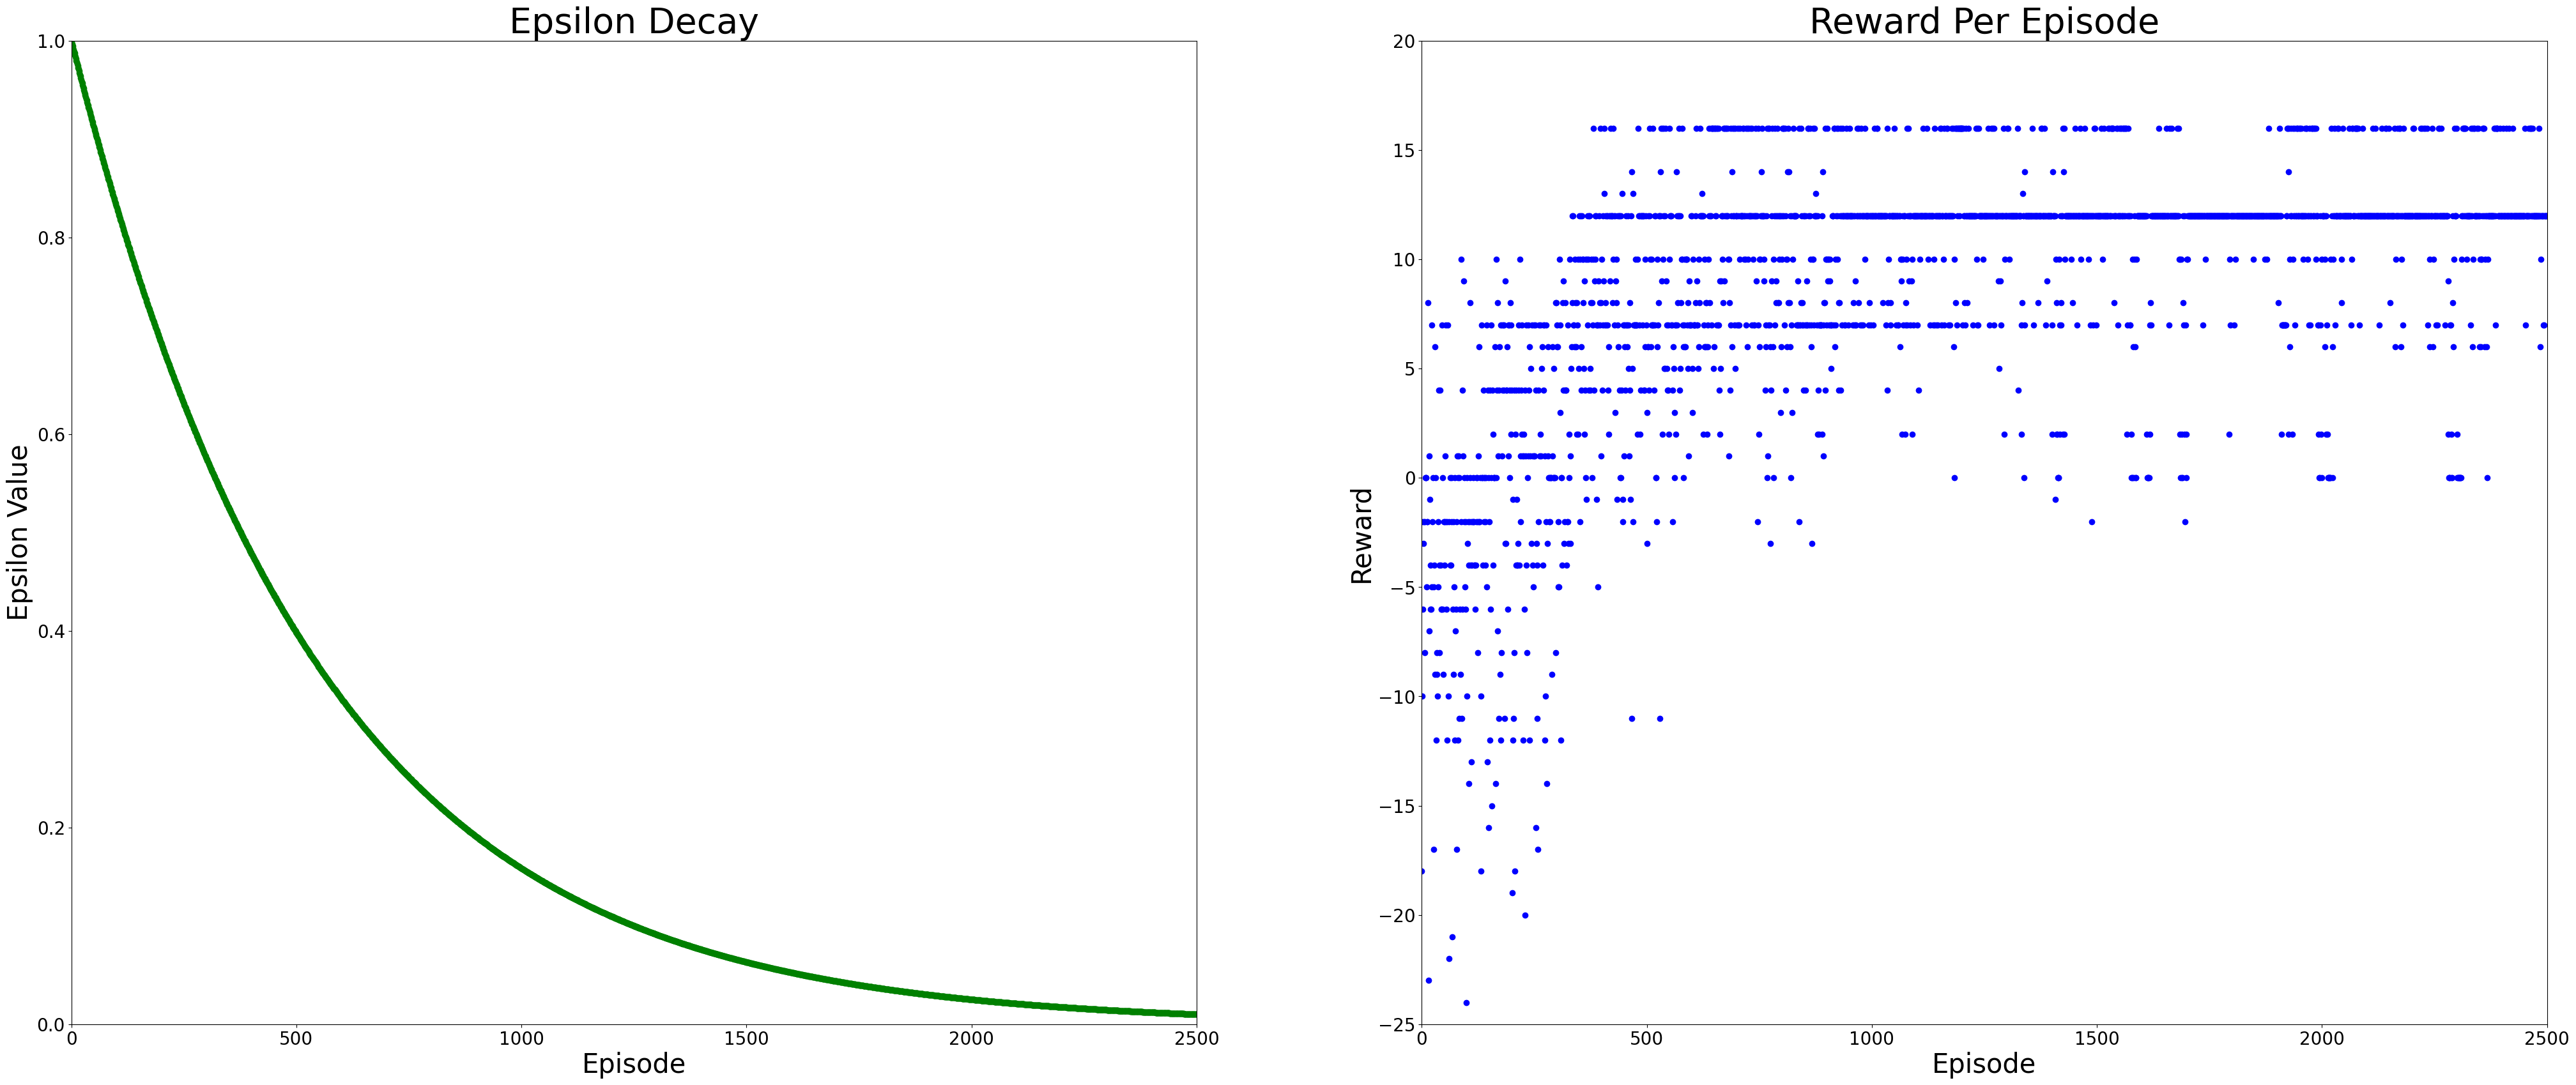

In [18]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_figheight(20)
fig.set_figwidth(50)
# fig.suptitle('Gamma Tuning', size="50")
ax1.plot(epsilon_list_train_dqn, 'go')
ax1.set_title("Epsilon Decay", size=40)
ax1.set_ylabel('Epsilon Value', fontsize = 30) 
ax1.set_xlabel('Episode', fontsize = 30)
ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)
ax1.set_xlim(100)
ax1.set_xlim(xmin=0, xmax=a.max_episodes)
ax1.set_ylim(ymin=0, ymax=1)
ax2.plot(reward_list_train_dqn, 'bo')
ax2.set_title(f"Reward Per Episode", size=40)
ax2.set_ylabel('Reward', fontsize = 30) 
ax2.set_xlabel('Episode', fontsize = 30)
ax2.tick_params(axis='x', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)
ax2.set_xlim(xmin=0, xmax=a.max_episodes)
ax2.set_ylim(ymin=-25, ymax=20)
plt.show()

In [19]:
rewardSD_train_dqn_avg = []
for s in np.split(np.array(reward_list_train_dqn), 25):
    rewardSD_train_dqn_avg.append((sum(s)/len(s)))
    
epsilonSD_train_dqn_avg = []
for s in np.split(np.array(epsilon_list_train_dqn), 25):
    epsilonSD_train_dqn_avg.append((sum(s)/len(s)))



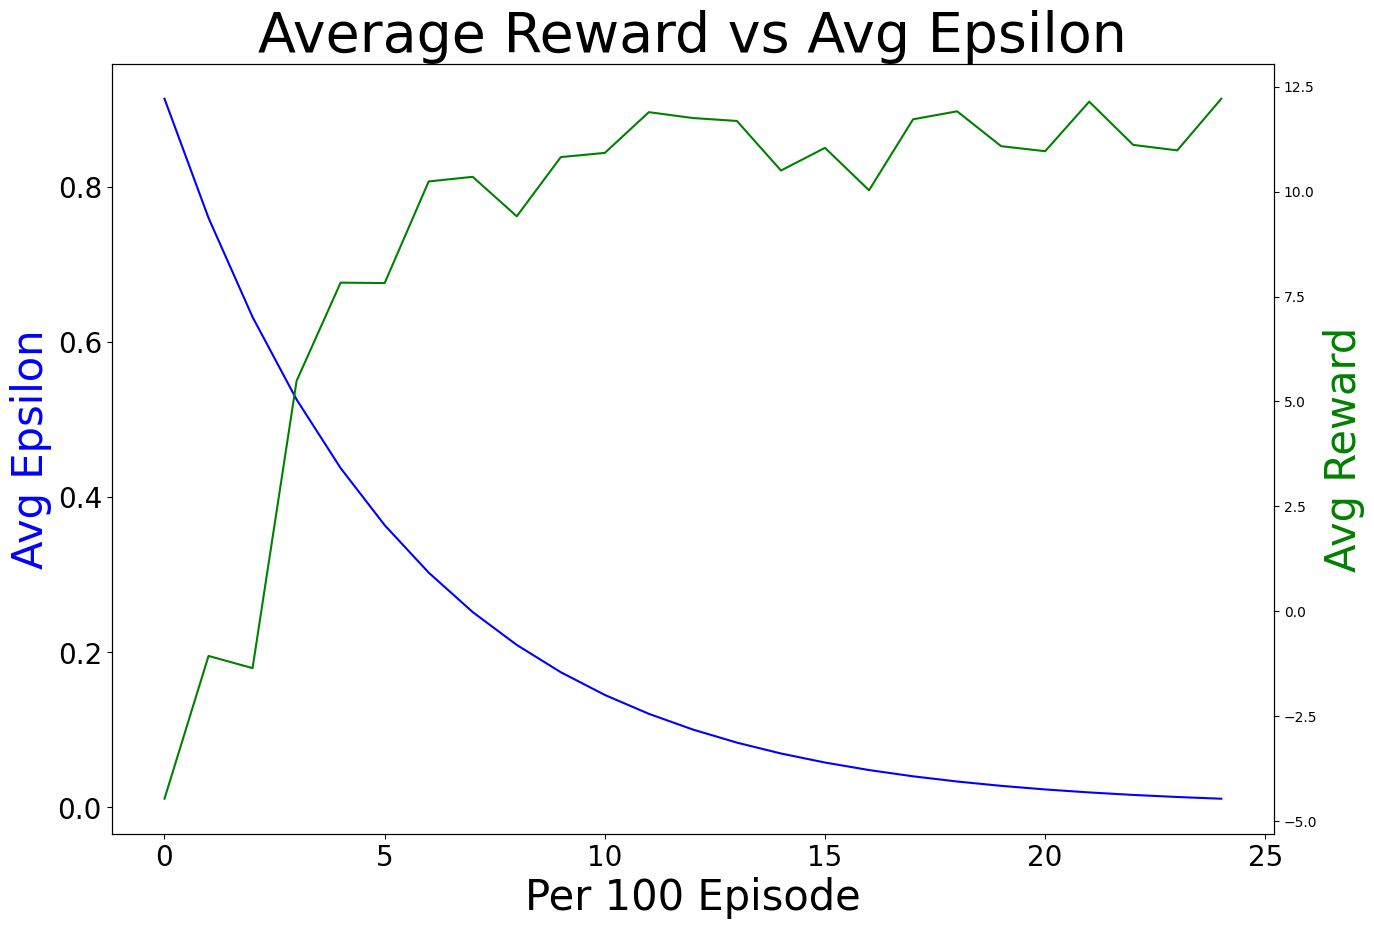

In [20]:
fig, ax1 = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(15)
plt.tick_params(axis='both', which='major', labelsize=20)
ax2 = ax1.twinx()
ax1.plot(epsilonSD_train_dqn_avg, 'b-')
ax2.plot(rewardSD_train_dqn_avg, 'g-')
ax1.set_title("Average Reward vs Avg Epsilon", size=40)
ax1.set_xlabel('Per 100 Episode', fontsize=30)
ax1.set_ylabel('Avg Epsilon', color='b', fontsize=30)
ax2.set_ylabel('Avg Reward', color='g', fontsize=30)
plt.show()

In [21]:
PATH = './grid.pth'
torch.save(a.q_value_dqn.state_dict(), PATH)

## Evaluating the agent

In [22]:
env = MyMarioEnvironment(environment_type = 'deterministic')
env.reset()
a = GridVanillaDQN(env)
a.eval()

/tmp/ipykernel_8068/3657155398.py:17: DeprecationWarning: CUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  T.Resize(84, interpolation=Image.CUBIC),
100%|██████████| 10/10 [00:00<00:00, 316.10episodes/s]


In [23]:
reward_list_test_dqn = a.test_rewards_list

In [25]:
print(reward_list_test_dqn)

[12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0]


## Plotting the results

<Figure size 640x480 with 0 Axes>

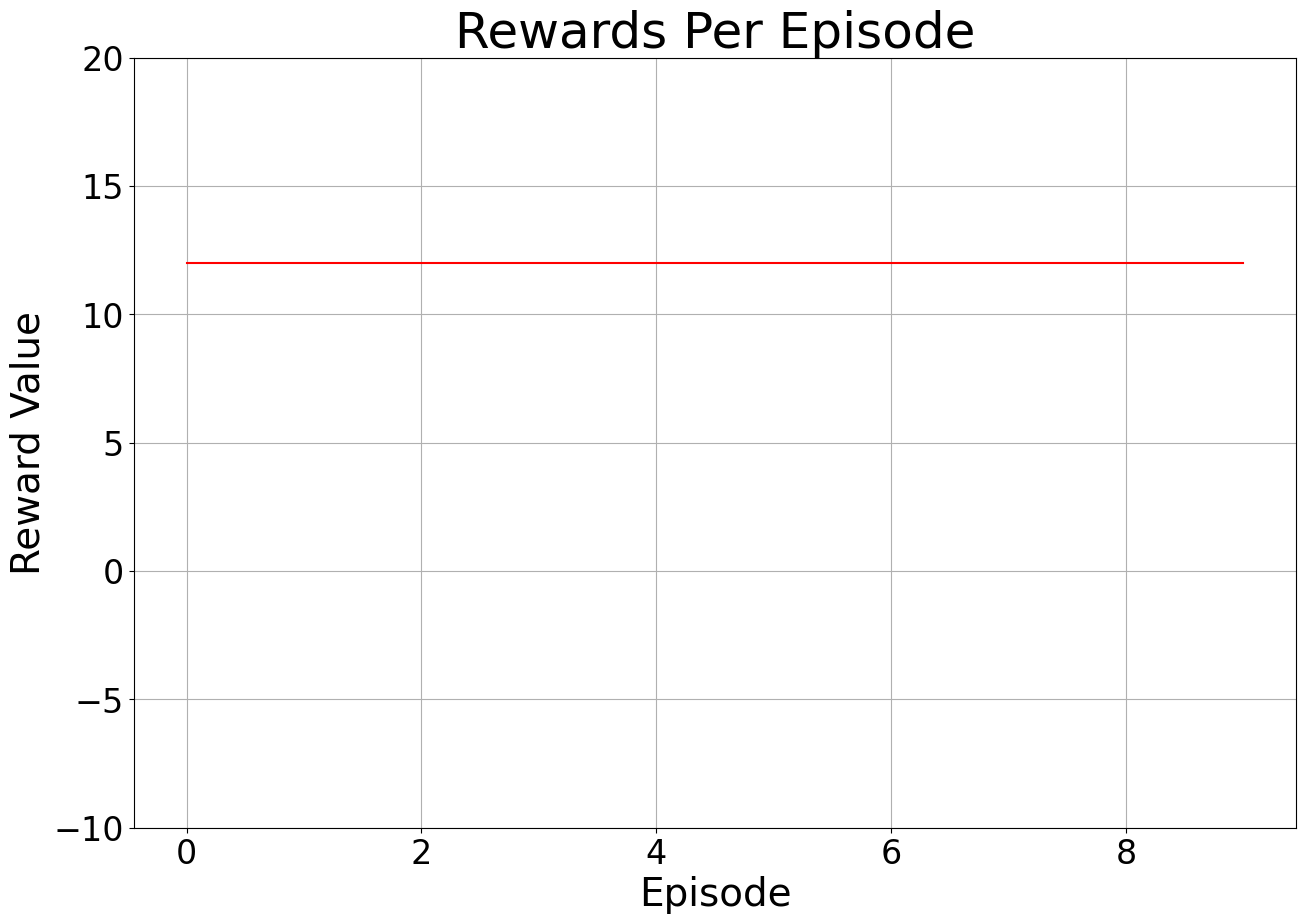

In [24]:
plt.clf()
plt.figure(figsize=(15, 10))
plt.plot(reward_list_test_dqn, 'r-')
plt.xlabel('Episode', fontsize=28)
plt.ylabel('Reward Value', fontsize=28)
plt.title(f'Rewards Per Episode', fontsize=36)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
# plt.yticks([-100, -50, 0, 10, 20], fontsize=24)
plt.ylim(ymin=-10, ymax=20)
# plt.xlim(xmin=0, xmax=self.max_episodes_test)
plt.grid()
plt.show()